# Higher Order Robust PCA
---

This notebook includes some tutorials on how to run `horpca` algorithm.

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
from sklearn.neighbors import kneighbors_graph
from omegaconf import OmegaConf
import os

import project_path

from util.horpca import horpca
from util.generate_data import generate_low_rank_data
from util.contaminate_data import contaminate_signal

#### Generate data

First, we generate low rank data with given size and rank, and then contaminate this with noise. Also, we mask some percentage of entries as unobserved, or missing.

In [2]:
sizes = [50,50,20]
ranks = [5,5,5]
n = len(sizes)
X = generate_low_rank_data([50,50,20], [5,5,5])

In [17]:
# Contaminate data.
Y = contaminate_signal(X, noise_rate=0.2, noise_type='gross', missing_ratio=0.01)


#### The Algorithm

Then, we run our algorithm to estimate the original signal.

In [53]:
alpha = [10**-2 for i in range(n)]
psi = [1 for _ in range(n)]

L, obj_val, terms, lam_val = horpca(
    Y,
    alpha = alpha,
    psi=psi,
    beta=1/np.sqrt(max(sizes)),
    max_iter=500,
    err_tol=1e-7,
    verbose=True
    )

Max Iter


Let's plot the convergence curve. We use the norm of the dual variable for this. One can also plot the objective value.

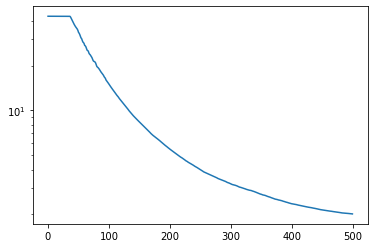

In [54]:
plt.semilogy(lam_val)

## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

In [55]:
print('Normalized error of the output: {:.2f}'.format(norm(X-L)/norm(X)))
res = X-Y
print('Normalized error of the input: {:.2f}'.format(norm(res.data)/norm(X)))


Normalized error of the output: 0.04
Normalized error of the input: 2.26
